# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [23]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

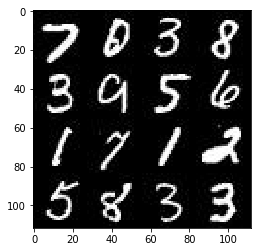

In [24]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

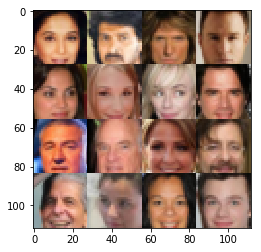

In [30]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [31]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [32]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    real_input = tf.placeholder(dtype=tf.float32,shape=(None,image_width,image_height,image_channels))
    z_data = tf.placeholder(dtype=tf.float32,shape=(None,z_dim))
    lr = tf.placeholder(dtype=tf.float32)
    return real_input, z_data, lr

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [33]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        #conv over input with leaky Relu and no batch_norm, images are 28x28x1-3
        x1 = tf.layers.conv2d(images,filters=32,kernel_size=5,strides=2,padding='SAME')
        x1 = tf.maximum(0.2*x1,x1)
        #Now 14x14x32
        
        x2 = tf.layers.conv2d(x1,filters=128,kernel_size=5,strides=2,padding='SAME')
        x2 = tf.layers.batch_normalization(x2,training=True)
        x2 = tf.maximum(0.2*x2,x2)
        #Now 7x7x128
        
        x3 = tf.layers.conv2d(x2,filters=256,kernel_size=5,strides=2,padding='SAME')
        x3 = tf.layers.batch_normalization(x3,training=True)
        x3 = tf.maximum(0.2*x3,x3)
        print ('x3_shape:{}'.format(x3.shape))
        #Now 4x4x256 ....odd division rounds up to 4**********************************
        
        flat = tf.reshape(x3,(-1,4*4*256)) 
        logits = tf.layers.dense(flat,1)
        print ("disc_logits_shape: {}".format(logits.shape))
        output = tf.sigmoid(logits)
        #print ("disc_output_shape: {}".format(output.shape))
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

x3_shape:(?, 4, 4, 256)
disc_logits_shape: (?, 1)
x3_shape:(?, 4, 4, 256)
disc_logits_shape: (?, 1)
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [34]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse= not is_train): #does reuse need to be a function parameter*********
        x = tf.layers.dense(z,7*7*512)
        x = tf.reshape(x,shape=[-1,7,7,512])
        x = tf.layers.batch_normalization(x,training=is_train)
        x = tf.maximum(0.2*x,x)
        #Now 7*7*512
        
        #t.Conv - batch_norm - leakyRelu
        x1 = tf.layers.conv2d_transpose(x, filters=256, kernel_size=5, strides=2, padding='SAME')
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        x1 = tf.maximum(0.2*x1,x1)
        #Now 14x14x256
        
        x2 = tf.layers.conv2d_transpose(x1, filters=64, kernel_size=5, strides=2, padding='SAME')
        x2 = tf.layers.batch_normalization(x2,training=is_train)
        x2 = tf.maximum(0.2*x2,x2)
        #Now 28x28x64
        print ("gen_x2_shape: {}".format(x2.shape))
        
        logits = tf.layers.conv2d_transpose(x2,filters=out_channel_dim, kernel_size=4, strides=1, padding='SAME')
        #28x28xOutput_channel_dim
        
        print ("gen_logits_shape: {}".format(logits.shape))
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

gen_x2_shape: (?, 28, 28, 64)
gen_logits_shape: (?, 28, 28, 5)
gen_x2_shape: (?, 28, 28, 64)
gen_logits_shape: (?, 28, 28, 5)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [35]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z,out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model,reuse=True)
        
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_model_fake),logits=d_logits_fake))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(d_model_fake),logits=d_logits_fake))
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_model_real),logits=d_logits_real))
    d_loss = d_loss_fake + d_loss_real
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

gen_x2_shape: (?, 28, 28, 64)
gen_logits_shape: (?, 28, 28, 4)
x3_shape:(?, 4, 4, 256)
disc_logits_shape: (?, 1)
x3_shape:(?, 4, 4, 256)
disc_logits_shape: (?, 1)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [53]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    gan_var = tf.trainable_variables()
    g_var = [var for var in gan_var if var.name.startswith('generator')] #Variable_object.name that startswith
    d_var = [var for var in gan_var if var.name.startswith('discriminator')] 
    
    #var_list: which variables to update when trying minimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(g_loss,var_list=g_var)
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(d_loss,var_list=d_var)
    return d_opt, g_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [54]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False), 
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [55]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width,image_height,image_channels,z_dim) 
    d_loss,g_loss = model_loss(input_real=input_real, input_z=input_z, out_channel_dim=image_channels)
    d_opt,g_opt = model_opt(d_loss=d_loss,g_loss=g_loss,learning_rate=lr,beta1=beta1)

    saver = tf.train.Saver()
    steps=0
    losses = []

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # TODO: Train Model
                steps += 1
                
                #Gen input
                batch_images *= 2
                batch_z = np.random.uniform(-1,1,size=(batch_size,z_dim))
                
                #Run Optimizers
                _ = sess.run(d_opt, feed_dict={input_real:batch_images , input_z:batch_z, lr:learning_rate}) #****KEY=LRate**
                _ = sess.run(g_opt, feed_dict={input_real:batch_images , input_z:batch_z, lr:learning_rate}) #****KEY=LRate***
                
                if steps % 20 == 0:
                    _ = train_loss_d = d_loss.eval({input_real:batch_images, input_z:batch_z})
                    _ = train_loss_g = g_loss.eval({input_z:batch_z})
                
                    print("Epoch {}/{}...".format(epoch_i, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                #why is reuse=false if we are doing inference
                if steps % 100 == 0:
                    _ = show_generator_output(sess=sess, n_images=16, input_z=input_z, out_channel_dim=image_channels, image_mode=data_image_mode)
        saver.save(sess, './generator.ckpt')
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

gen_x2_shape: (?, 28, 28, 64)
gen_logits_shape: (?, 28, 28, 1)
x3_shape:(?, 4, 4, 256)
disc_logits_shape: (?, 1)
x3_shape:(?, 4, 4, 256)
disc_logits_shape: (?, 1)
Epoch 0/2... Discriminator Loss: 0.0858... Generator Loss: 3.3455
Epoch 0/2... Discriminator Loss: 0.0729... Generator Loss: 3.0337
Epoch 0/2... Discriminator Loss: 3.6935... Generator Loss: 0.0458
Epoch 0/2... Discriminator Loss: 1.1714... Generator Loss: 1.1175
Epoch 0/2... Discriminator Loss: 1.0175... Generator Loss: 0.9527
gen_x2_shape: (?, 28, 28, 64)
gen_logits_shape: (?, 28, 28, 1)


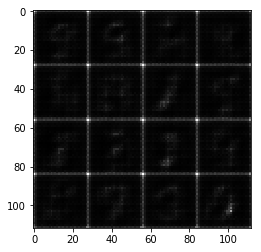

Epoch 0/2... Discriminator Loss: 1.1115... Generator Loss: 0.9010
Epoch 0/2... Discriminator Loss: 1.1141... Generator Loss: 1.2813
Epoch 0/2... Discriminator Loss: 1.1097... Generator Loss: 0.8882
Epoch 0/2... Discriminator Loss: 1.2518... Generator Loss: 0.5684
Epoch 0/2... Discriminator Loss: 1.0555... Generator Loss: 0.9318
gen_x2_shape: (?, 28, 28, 64)
gen_logits_shape: (?, 28, 28, 1)


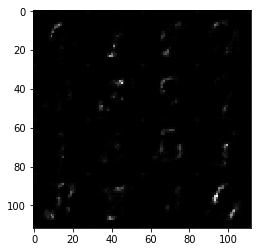

Epoch 0/2... Discriminator Loss: 0.9422... Generator Loss: 1.1400
Epoch 0/2... Discriminator Loss: 0.9960... Generator Loss: 0.8638
Epoch 0/2... Discriminator Loss: 1.1440... Generator Loss: 0.5643
Epoch 0/2... Discriminator Loss: 0.9300... Generator Loss: 0.7929
Epoch 0/2... Discriminator Loss: 0.8371... Generator Loss: 0.9715
gen_x2_shape: (?, 28, 28, 64)
gen_logits_shape: (?, 28, 28, 1)


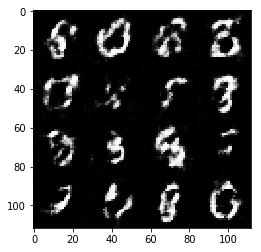

Epoch 0/2... Discriminator Loss: 0.8112... Generator Loss: 1.2127
Epoch 0/2... Discriminator Loss: 0.8523... Generator Loss: 0.8606
Epoch 0/2... Discriminator Loss: 1.0008... Generator Loss: 1.6762
Epoch 0/2... Discriminator Loss: 0.9713... Generator Loss: 1.2250
Epoch 0/2... Discriminator Loss: 0.9695... Generator Loss: 1.0021
gen_x2_shape: (?, 28, 28, 64)
gen_logits_shape: (?, 28, 28, 1)


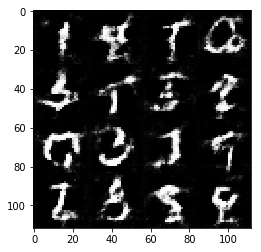

Epoch 0/2... Discriminator Loss: 1.5461... Generator Loss: 0.3153
Epoch 0/2... Discriminator Loss: 1.0543... Generator Loss: 0.9197
Epoch 0/2... Discriminator Loss: 1.0383... Generator Loss: 0.6748
Epoch 1/2... Discriminator Loss: 1.1555... Generator Loss: 0.5987
Epoch 1/2... Discriminator Loss: 1.2211... Generator Loss: 0.6055
gen_x2_shape: (?, 28, 28, 64)
gen_logits_shape: (?, 28, 28, 1)


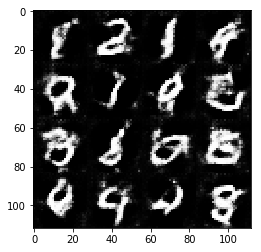

Epoch 1/2... Discriminator Loss: 1.1217... Generator Loss: 1.4570
Epoch 1/2... Discriminator Loss: 1.2375... Generator Loss: 1.7718
Epoch 1/2... Discriminator Loss: 1.1445... Generator Loss: 0.5946
Epoch 1/2... Discriminator Loss: 1.0695... Generator Loss: 0.8421
Epoch 1/2... Discriminator Loss: 1.0688... Generator Loss: 1.1883
gen_x2_shape: (?, 28, 28, 64)
gen_logits_shape: (?, 28, 28, 1)


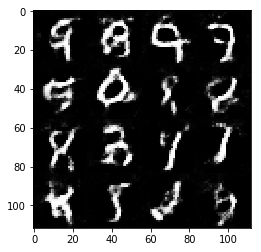

Epoch 1/2... Discriminator Loss: 1.0504... Generator Loss: 1.3387
Epoch 1/2... Discriminator Loss: 1.2014... Generator Loss: 0.5473
Epoch 1/2... Discriminator Loss: 1.0225... Generator Loss: 1.7024
Epoch 1/2... Discriminator Loss: 1.0690... Generator Loss: 1.1075
Epoch 1/2... Discriminator Loss: 0.9949... Generator Loss: 1.1872
gen_x2_shape: (?, 28, 28, 64)
gen_logits_shape: (?, 28, 28, 1)


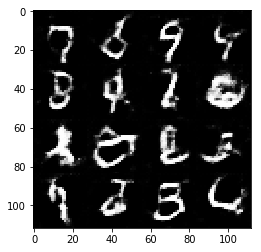

Epoch 1/2... Discriminator Loss: 1.0979... Generator Loss: 0.6424
Epoch 1/2... Discriminator Loss: 1.0603... Generator Loss: 1.1310
Epoch 1/2... Discriminator Loss: 0.9944... Generator Loss: 0.9206
Epoch 1/2... Discriminator Loss: 1.3587... Generator Loss: 0.3984
Epoch 1/2... Discriminator Loss: 1.2442... Generator Loss: 0.4719
gen_x2_shape: (?, 28, 28, 64)
gen_logits_shape: (?, 28, 28, 1)


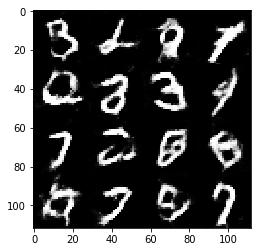

Epoch 1/2... Discriminator Loss: 1.0125... Generator Loss: 0.7380
Epoch 1/2... Discriminator Loss: 1.0765... Generator Loss: 1.6279
Epoch 1/2... Discriminator Loss: 1.1557... Generator Loss: 0.5528
Epoch 1/2... Discriminator Loss: 0.9831... Generator Loss: 1.0793
Epoch 1/2... Discriminator Loss: 0.8705... Generator Loss: 1.1495
gen_x2_shape: (?, 28, 28, 64)
gen_logits_shape: (?, 28, 28, 1)


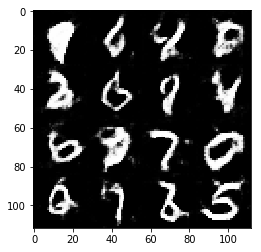

Epoch 1/2... Discriminator Loss: 0.9859... Generator Loss: 1.4470


In [56]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

gen_x2_shape: (?, 28, 28, 64)
gen_logits_shape: (?, 28, 28, 3)
x3_shape:(?, 4, 4, 256)
disc_logits_shape: (?, 1)
x3_shape:(?, 4, 4, 256)
disc_logits_shape: (?, 1)
Epoch 0/1... Discriminator Loss: 0.9580... Generator Loss: 0.8328
Epoch 0/1... Discriminator Loss: 0.6728... Generator Loss: 1.1617
Epoch 0/1... Discriminator Loss: 1.1161... Generator Loss: 0.8068
Epoch 0/1... Discriminator Loss: 1.0597... Generator Loss: 1.1261
Epoch 0/1... Discriminator Loss: 1.1700... Generator Loss: 0.8137
gen_x2_shape: (?, 28, 28, 64)
gen_logits_shape: (?, 28, 28, 3)


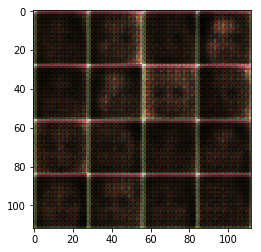

Epoch 0/1... Discriminator Loss: 1.2375... Generator Loss: 1.4256
Epoch 0/1... Discriminator Loss: 0.7508... Generator Loss: 2.3309
Epoch 0/1... Discriminator Loss: 1.5056... Generator Loss: 0.4496
Epoch 0/1... Discriminator Loss: 0.6781... Generator Loss: 1.4988
Epoch 0/1... Discriminator Loss: 0.6152... Generator Loss: 1.5947
gen_x2_shape: (?, 28, 28, 64)
gen_logits_shape: (?, 28, 28, 3)


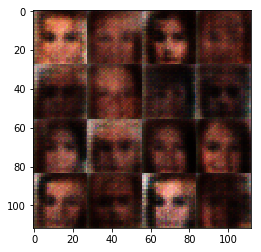

Epoch 0/1... Discriminator Loss: 0.7402... Generator Loss: 1.2425
Epoch 0/1... Discriminator Loss: 1.0104... Generator Loss: 0.8259
Epoch 0/1... Discriminator Loss: 1.1601... Generator Loss: 0.7199
Epoch 0/1... Discriminator Loss: 2.5474... Generator Loss: 0.1309
Epoch 0/1... Discriminator Loss: 1.2428... Generator Loss: 0.6252
gen_x2_shape: (?, 28, 28, 64)
gen_logits_shape: (?, 28, 28, 3)


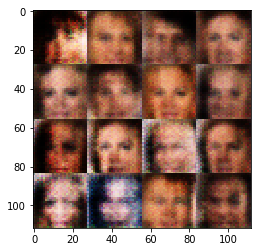

Epoch 0/1... Discriminator Loss: 0.6203... Generator Loss: 2.6932
Epoch 0/1... Discriminator Loss: 1.0968... Generator Loss: 0.6248
Epoch 0/1... Discriminator Loss: 0.4587... Generator Loss: 2.5319
Epoch 0/1... Discriminator Loss: 0.2295... Generator Loss: 3.8071
Epoch 0/1... Discriminator Loss: 0.3889... Generator Loss: 1.5649
gen_x2_shape: (?, 28, 28, 64)
gen_logits_shape: (?, 28, 28, 3)


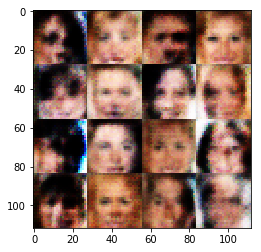

Epoch 0/1... Discriminator Loss: 0.2248... Generator Loss: 3.5994
Epoch 0/1... Discriminator Loss: 1.0971... Generator Loss: 0.5176
Epoch 0/1... Discriminator Loss: 0.5875... Generator Loss: 3.1503
Epoch 0/1... Discriminator Loss: 0.5311... Generator Loss: 1.9056
Epoch 0/1... Discriminator Loss: 0.3169... Generator Loss: 2.2138
gen_x2_shape: (?, 28, 28, 64)
gen_logits_shape: (?, 28, 28, 3)


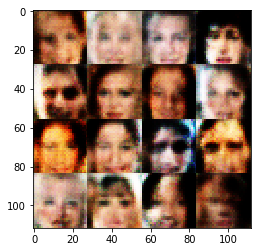

Epoch 0/1... Discriminator Loss: 0.7389... Generator Loss: 0.9598
Epoch 0/1... Discriminator Loss: 0.2266... Generator Loss: 3.4919
Epoch 0/1... Discriminator Loss: 0.7938... Generator Loss: 0.7652
Epoch 0/1... Discriminator Loss: 0.3210... Generator Loss: 2.3693
Epoch 0/1... Discriminator Loss: 0.9150... Generator Loss: 0.7014
gen_x2_shape: (?, 28, 28, 64)
gen_logits_shape: (?, 28, 28, 3)


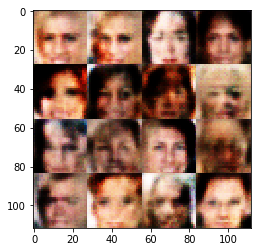

Epoch 0/1... Discriminator Loss: 0.2605... Generator Loss: 4.0775
Epoch 0/1... Discriminator Loss: 0.2457... Generator Loss: 2.2333
Epoch 0/1... Discriminator Loss: 0.1625... Generator Loss: 3.5207
Epoch 0/1... Discriminator Loss: 0.1666... Generator Loss: 3.4536
Epoch 0/1... Discriminator Loss: 0.2064... Generator Loss: 2.6418
gen_x2_shape: (?, 28, 28, 64)
gen_logits_shape: (?, 28, 28, 3)


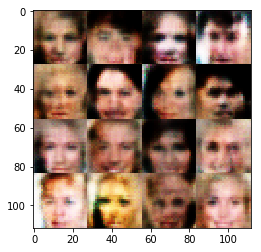

Epoch 0/1... Discriminator Loss: 0.3733... Generator Loss: 4.4503
Epoch 0/1... Discriminator Loss: 0.3326... Generator Loss: 1.6583
Epoch 0/1... Discriminator Loss: 0.7990... Generator Loss: 4.9428
Epoch 0/1... Discriminator Loss: 0.2901... Generator Loss: 3.6189
Epoch 0/1... Discriminator Loss: 0.2279... Generator Loss: 2.4871
gen_x2_shape: (?, 28, 28, 64)
gen_logits_shape: (?, 28, 28, 3)


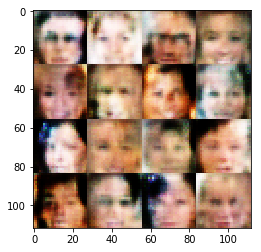

Epoch 0/1... Discriminator Loss: 1.3287... Generator Loss: 0.3846
Epoch 0/1... Discriminator Loss: 1.2854... Generator Loss: 3.7594
Epoch 0/1... Discriminator Loss: 0.2442... Generator Loss: 3.3029
Epoch 0/1... Discriminator Loss: 0.2319... Generator Loss: 3.5822
Epoch 0/1... Discriminator Loss: 0.5079... Generator Loss: 3.0165
gen_x2_shape: (?, 28, 28, 64)
gen_logits_shape: (?, 28, 28, 3)


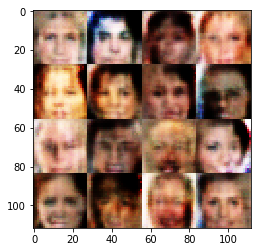

Epoch 0/1... Discriminator Loss: 0.4247... Generator Loss: 3.9301
Epoch 0/1... Discriminator Loss: 0.1994... Generator Loss: 4.0692
Epoch 0/1... Discriminator Loss: 0.5876... Generator Loss: 3.0679
Epoch 0/1... Discriminator Loss: 0.6423... Generator Loss: 1.9033
Epoch 0/1... Discriminator Loss: 0.5187... Generator Loss: 1.3583
gen_x2_shape: (?, 28, 28, 64)
gen_logits_shape: (?, 28, 28, 3)


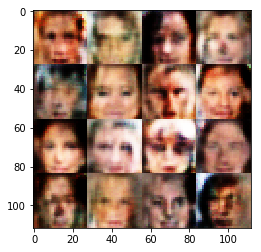

Epoch 0/1... Discriminator Loss: 0.4850... Generator Loss: 1.8504
Epoch 0/1... Discriminator Loss: 0.3956... Generator Loss: 1.5025
Epoch 0/1... Discriminator Loss: 0.2427... Generator Loss: 3.1760
Epoch 0/1... Discriminator Loss: 2.6452... Generator Loss: 0.1183
Epoch 0/1... Discriminator Loss: 0.4428... Generator Loss: 3.5702
gen_x2_shape: (?, 28, 28, 64)
gen_logits_shape: (?, 28, 28, 3)


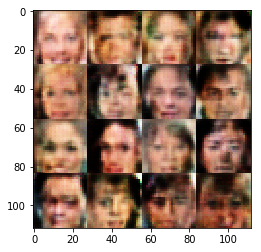

Epoch 0/1... Discriminator Loss: 0.6456... Generator Loss: 0.9393
Epoch 0/1... Discriminator Loss: 0.9246... Generator Loss: 0.6816
Epoch 0/1... Discriminator Loss: 0.1342... Generator Loss: 4.8356
Epoch 0/1... Discriminator Loss: 0.2544... Generator Loss: 2.2263
Epoch 0/1... Discriminator Loss: 0.6598... Generator Loss: 2.1556
gen_x2_shape: (?, 28, 28, 64)
gen_logits_shape: (?, 28, 28, 3)


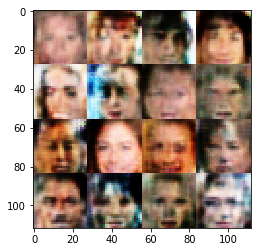

Epoch 0/1... Discriminator Loss: 1.8071... Generator Loss: 2.9231
Epoch 0/1... Discriminator Loss: 0.3017... Generator Loss: 2.8069
Epoch 0/1... Discriminator Loss: 0.5035... Generator Loss: 1.2581
Epoch 0/1... Discriminator Loss: 0.2546... Generator Loss: 2.3453
Epoch 0/1... Discriminator Loss: 0.1767... Generator Loss: 2.7569
gen_x2_shape: (?, 28, 28, 64)
gen_logits_shape: (?, 28, 28, 3)


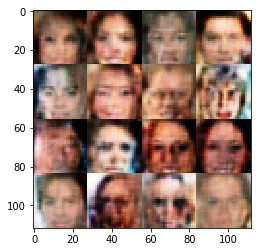

Epoch 0/1... Discriminator Loss: 0.2329... Generator Loss: 3.1359
Epoch 0/1... Discriminator Loss: 0.3731... Generator Loss: 1.6222
Epoch 0/1... Discriminator Loss: 0.3556... Generator Loss: 2.1376
Epoch 0/1... Discriminator Loss: 0.4770... Generator Loss: 2.4905
Epoch 0/1... Discriminator Loss: 0.3233... Generator Loss: 1.6655
gen_x2_shape: (?, 28, 28, 64)
gen_logits_shape: (?, 28, 28, 3)


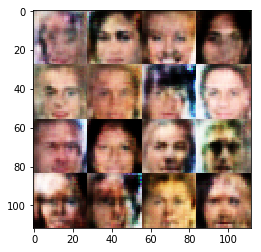

Epoch 0/1... Discriminator Loss: 0.3767... Generator Loss: 2.5282
Epoch 0/1... Discriminator Loss: 0.9096... Generator Loss: 1.2429
Epoch 0/1... Discriminator Loss: 0.4569... Generator Loss: 2.7773
Epoch 0/1... Discriminator Loss: 0.2116... Generator Loss: 3.2316
Epoch 0/1... Discriminator Loss: 1.3863... Generator Loss: 0.4018
gen_x2_shape: (?, 28, 28, 64)
gen_logits_shape: (?, 28, 28, 3)


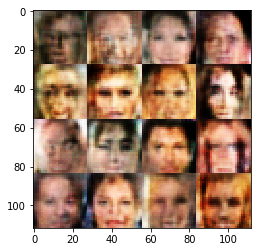

Epoch 0/1... Discriminator Loss: 0.7006... Generator Loss: 0.9937
Epoch 0/1... Discriminator Loss: 0.2084... Generator Loss: 2.7592
Epoch 0/1... Discriminator Loss: 0.2546... Generator Loss: 2.0379
Epoch 0/1... Discriminator Loss: 0.4450... Generator Loss: 1.7410


In [57]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.